In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "experiments/LLB16_Whisperseg_NoNormNoThresholding/saved_weights/model_step_21000.pth"
config_path = "experiments/LLB16_Whisperseg_NoNormNoThresholding/config.json"

tweety_bert_model = load_model(config_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [2]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image, deterimine_number_unique_classes

train_dir = "/home/george-vengrovski/Documents/data/llb16_no_threshold_no_norm_train"
test_dir = "/home/george-vengrovski/Documents/data/llb16_no_threshold_no_norm_test"

num_classes = deterimine_number_unique_classes(train_dir)

train_dataset = SongDataSet_Image(train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [3]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=-1, layer_id="feed_forward_output", TweetyBERT_readout_dims=196, classifier_type="linear_probe")
classifier_model = classifier_model.to(device)

Step 250: Train Loss 0.2729 FER = 6.74%, Val Loss = 0.2271
Step 500: Train Loss 0.3990 FER = 7.51%, Val Loss = 0.2491
Step 750: Train Loss 0.2546 FER = 8.49%, Val Loss = 0.3286
Step 1000: Train Loss 0.3736 FER = 6.18%, Val Loss = 0.2094
Step 1250: Train Loss 0.3884 FER = 7.93%, Val Loss = 0.2429
Step 1500: Train Loss 0.9382 FER = 10.64%, Val Loss = 0.3823
Step 1750: Train Loss 0.1580 FER = 10.23%, Val Loss = 0.4428
Early stopping triggered


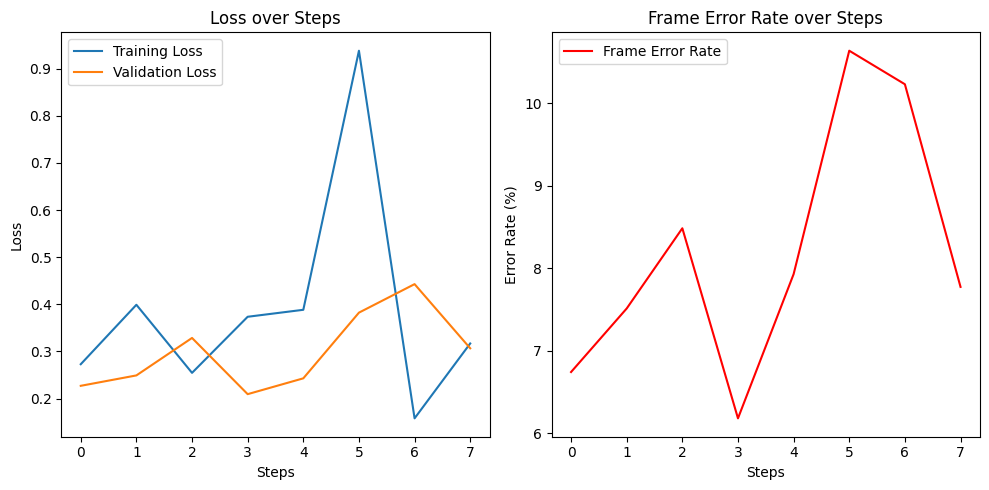

In [4]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-4, plotting=True, batches_per_eval=250, desired_total_batches=5000, patience=4)
weight_differences = trainer.train()

## Analyze

In [5]:
from linear_probe import ModelEvaluator

# Initialize the ModelEvaluator with the filter_unseen_classes feature
evaluator = ModelEvaluator(model=classifier_model, 
                           test_loader=test_loader, 
                           num_classes=num_classes,  # Assuming there are 21 possible classes
                           device='cuda:0',  # Use CUDA if available
                           filter_unseen_classes=True,  # Enable filtering based on training set classes
                           train_dir=train_dir)  # Path to the training dataset directory

# Perform model validation with multiple passes
class_frame_error_rates, total_frame_error_rate = evaluator.evalulate_model(num_passes=1, max_batches=1250)

# Save the results to a specified directory, for example 'evaluation_results'
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, 'results/')
